In [151]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import os
import glob
import cv2 # 专用于处理计算机视觉场景文件的包 pip install opencv-python 执行安装
import json
import time
# 查询系统可用的 GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
# 确保有可用的 GPU 如果没有, 则会报错
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
# 设置参数,该段务必在运行jupyter的第一段代码执行，否则会无法初始化成功
# 仅在需要时申请显存空间（程序初始运行时消耗很少的显存，随着程序的运行而动态申请显存）
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [153]:
# 读取每一个csv.gz文件 -> label 已经生成  -> drawing 如何处理需要思考

##### 通过作图对数据做一次单通道和RGB形式的预览

In [155]:
# 单通道作图函数定义
def draw_cv2(raw_strokes, size = 256, lw = 6, time_color = True):
    img = np.zeros((BASE_SIZE, BASE_SIZE), np.uint8)  # 定义画板
    for t, stroke in enumerate(raw_strokes):
        for i in range(len(stroke[0]) - 1):
            color = 255 - min(t, 10) * 13 if time_color else 255

            _ = cv2.line(img, (stroke[0][i],stroke[1][i]),
                (stroke[0][i+1],stroke[1][i+1]), color, lw
            )
    
    if size != BASE_SIZE:
        return cv2.resize(img, (size, size))
    else:
        return img

In [157]:
fileList = glob.glob('/data/python/tensorflow/shuffle_data_gzip/*.csv.gz')
sample = json.loads(pd.read_csv(fileList[0]).loc[0,'drawing'])

In [159]:
pd.read_csv(fileList[0]).head(5)

,countrycode,drawing,recognized,timestamp,word,y,cv
0,US,"[[[0, 132, 240, 255], [104, 103, 95, 91]], [[7...",True,2017-03-17 18:14:34.530070,yoga,337,22
1,DE,"[[[0, 4, 16, 11, 11, 32, 35, 51, 52, 62], [0, ...",True,2017-01-31 13:18:40.691300,river,240,22
2,US,"[[[223, 218, 200, 180, 167, 166, 170, 25, 1, 0...",True,2017-03-13 16:28:26.997050,key,159,22
3,PS,"[[[243, 223, 125, 122], [69, 72, 72, 76]], [[1...",True,2017-03-15 20:11:14.057590,truck,321,22
4,NO,"[[[43, 36, 30, 30, 25, 26, 34, 41, 53, 142, 18...",True,2017-03-15 09:43:26.128100,pants,206,22


In [161]:
json.loads(pd.read_csv(fileList[0]).loc[1,'drawing'])

[[[0, 4, 16, 11, 11, 32, 35, 51, 52, 62],
  [0, 9, 24, 42, 54, 96, 143, 187, 232, 255]]]

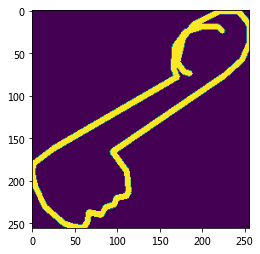

In [163]:
BASE_SIZE = 256
plt.imshow(draw_cv2(json.loads(pd.read_csv(fileList[0]).loc[2,'drawing']),time_color = False))

In [165]:
sample

[[[0, 132, 240, 255], [104, 103, 95, 91]],
 [[7, 63, 94, 164, 164, 152, 176, 206], [96, 50, 32, 33, 42, 90, 92, 85]],
 [[190, 178, 158, 157, 170, 183, 202, 202, 192, 184],
  [4, 3, 16, 27, 42, 44, 25, 9, 1, 0]]]

In [167]:
sample[0]

[[0, 132, 240, 255], [104, 103, 95, 91]]

In [169]:
sample[1]

[[7, 63, 94, 164, 164, 152, 176, 206], [96, 50, 32, 33, 42, 90, 92, 85]]

In [171]:
sample[2]

[[190, 178, 158, 157, 170, 183, 202, 202, 192, 184],
 [4, 3, 16, 27, 42, 44, 25, 9, 1, 0]]

In [173]:
np.array(sample).shape

(3, 2)

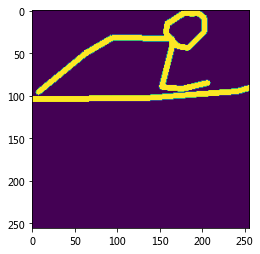

In [175]:
BASE_SIZE = 256
plt.imshow(draw_cv2(sample,time_color = False))

In [177]:
# RGB图片预览
def draw_cv2_rgb(raw_strokes, size = 256, lw = 6):
    img = np.zeros((BASE_SIZE, BASE_SIZE,3), np.uint8)  # 定义画板
    for t, stroke in enumerate(raw_strokes):
        points_count = len(stroke[0]) - 1
        grad = 255//points_count
        for i in range(len(stroke[0]) - 1):
            _ = cv2.line(
                img, 
                (stroke[0][i],stroke[1][i]),
                (stroke[0][i+1],stroke[1][i+1]),
                (255,255-min(t, 10) * 13, max(255 - grad *i, 20)),
                lw
            )
    
    if size != BASE_SIZE:
        return cv2.resize(img, (size, size))
    else:
        return img

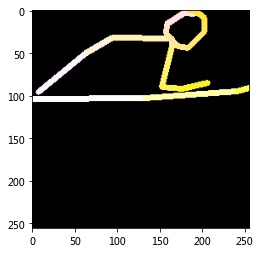

In [179]:
plt.imshow(draw_cv2_rgb(sample))

In [206]:
class Dataloader(object):
    def __init__(self, resize_height =64, resize_width = 64, batch_size = 512, fileList = None, size = 256, lw = 6):
        self.resize_height = resize_height # 图片的高度
        self.resize_width = resize_width # 图片的宽度
        self.batch_size = batch_size # batch大小
        self.fileList = fileList # 文件数据
        self.size = size # 画图时图片的大小
        self.lw = lw

    def __call__(self):
        def _generator(size, lw):
            while True: # 对所有的数据进行读取
                for filename in np.random.permutation(self.fileList):
                    df = pd.read_csv(filename)
                    df['drawing'] = df['drawing'].apply(json.loads) # 转换一下数据格式
                    x = np.zeros((len(df), size, size))

                    for i, raw_strokes in enumerate(df.drawing.values):
                        x[i] = draw_cv2(raw_strokes, size =size, lw = lw)
                    
                    x = x/ 255.0
                    x = x.reshape((len(df), size, size, 1)).astype(np.float32)  #这里转换为黑白图像
                    y = tf.keras.utils.to_categorical(df.y, num_classes = n_labels)

                    for x_i, y_i in zip(x,y):
                        yield(x_i, y_i)


                
        dataset = tf.data.Dataset.from_generator(
            generator = _generator,
            output_types=(tf.dtypes.float32, tf.dtypes.float32),
            output_shapes=((self.resize_height, self.resize_width, 1), (340, )),
            args=(self.size, self.lw)
        )

        dataset = dataset.prefetch(buffer_size = 10240)
        dataset = dataset.shuffle(buffer_size = 10240).batch(self.batch_size)

        return dataset

In [207]:
DP_DIR = '/data/python/tensorflow/shuffle_data_gzip/'

In [208]:
BASE_SIZE = 256
n_labels = 340
np.random.seed(seed = 1987)
size = 64
batchsize = 1024
fileList = glob.glob('/data/python/tensorflow/shuffle_data_gzip/*.csv.gz')

# 取最后一个做验证集
train_fileList = fileList[:-1]
val_fileList = fileList[-1:]

train_ds = Dataloader(resize_height=64, resize_width=64, batch_size=batchsize, fileList= train_fileList, size = size, lw = 6)()
val_ds = Dataloader(resize_height=64, resize_width=64, batch_size=batchsize, fileList= val_fileList, size = size, lw = 6)()

In [209]:
val_fileList

['/data/python/tensorflow/shuffle_data_gzip/train_k2.csv.gz']

In [210]:
type(val_ds)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [211]:
inputs = tf.keras.layers.Input(shape = (size, size, 1))
base_model = tf.keras.applications.MobileNet(input_shape = (size, size, 1), include_top=False, weights=None, classes= n_labels)

x = base_model(inputs)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
predictions = tf.keras.layers.Dense(n_labels, activation= 'softmax')(x)
model = tf.keras.models.Model(inputs = inputs, outputs = predictions)

In [216]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(lr = 0.002),
    loss = 'categorical_crossentropy',
    metrics = [
        tf.keras.metrics.CategoricalCrossentropy(),
        tf.keras.metrics.CategoricalAccuracy(),
        tf.keras.metrics.TopKCategoricalAccuracy(k = 3, name = 'top_3_categorical_Accuracy')
    ]
)

In [217]:
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 64, 64, 1)]       0         
_________________________________________________________________
mobilenet_1.00_64 (Model)    (None, 2, 2, 1024)        3228288   
_________________________________________________________________
flatten_6 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 1024)              4195328   
_________________________________________________________________
dense_13 (Dense)             (None, 340)               348500    
Total params: 7,772,116
Trainable params: 7,750,228
Non-trainable params: 21,888
_________________________________________________________________


In [218]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_top_3_categorical_accuracy', factor = 0.75, patience=3, min_delta = 0.001, mode = 'max', min_lr = 1e-5, verbose= 1),
    tf.keras.callbacks.ModelCheckpoint('model_all.h5', monitor = 'val_top_3_categorical_accuracy', mode = 'max', save_best_only= True, save_weights_only= True)
]

In [221]:
model.fit(
    train_ds, epochs = 5, verbose = 1, steps_per_epoch = 1000, # 定义一个epoch用多少个step
    validation_data = val_ds,
    validation_steps= 400,
    callbacks= callbacks
)

Epoch 1/5
1000/1000 [==============================] - 476s 476ms/step - loss: 1.3781 - categorical_crossentropy: 1.3781 - categorical_accuracy: 0.6585 - top_3_categorical_Accuracy: 0.8345 - val_loss: 1.5072 - val_categorical_crossentropy: 1.5072 - val_categorical_accuracy: 0.6317 - val_top_3_categorical_Accuracy: 0.8174 - lr: 0.0020
Epoch 2/5
1000/1000 [==============================] - 476s 476ms/step - loss: 1.2821 - categorical_crossentropy: 1.2821 - categorical_accuracy: 0.6804 - top_3_categorical_Accuracy: 0.8498 - val_loss: 1.3810 - val_categorical_crossentropy: 1.3810 - val_categorical_accuracy: 0.6592 - val_top_3_categorical_Accuracy: 0.8357 - lr: 0.0020
Epoch 3/5
1000/1000 [==============================] - 475s 475ms/step - loss: 1.2224 - categorical_crossentropy: 1.2224 - categorical_accuracy: 0.6941 - top_3_categorical_Accuracy: 0.8595 - val_loss: 1.3090 - val_categorical_crossentropy: 1.3090 - val_categorical_accuracy: 0.6736 - val_top_3_categorical_Accuracy: 0.8468 - lr:

In [222]:
def apk(actual, predicted, k = 10):
    # 这里在求min函数部分
    if len(predicted) > k :
        predicted = predicted[:k]

    # 初始化
    score = 0.0
    num_hits = 0.0

    # 对预测值的结果分别将序号和预测值做键值对
    # 遍历预测值的顺序和值
    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / ( i + 1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)


def mapk(actual, predicted, k =3):
    '''
    参见如下链接
    https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
    '''

    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])


##### 暂未构建测试集对数据进行预测
test_ds = 

model.predict()